In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, MobileNetV2, ResNet50
from vit_keras import vit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Define directories
data_dir ='M:\projects\Major_proj\Fruits_Dataset\Papaya\papaya_image'
batch_size = 32
image_size = (224, 224)

# Image Data Generator for preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of data for validation
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

num_classes = train_generator.num_classes

# Define a function to build the model
def build_model(base_model):
    base_model.trainable = False
    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# VGG16 model
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model = build_model(vgg_base)

# MobileNetV2 model
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenet_model = build_model(mobilenet_base)

# ResNet50 model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model = build_model(resnet_base)

# Vision Transformer model
vit_model = vit.vit_b16(
    image_size=224,
    pretrained=True,
    include_top=False,
    pretrained_top=False
)

vit_inputs = Input(shape=(224, 224, 3))
x = vit_model(vit_inputs)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
vit_outputs = Dense(num_classes, activation='softmax')(x)
vit_model = Model(vit_inputs, vit_outputs)
vit_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train and evaluate models
models = {
    "VGG16": vgg_model,
    "MobileNetV2": mobilenet_model,
    "ResNet50": resnet_model,
    "VisionTransformer": vit_model
}

history_dict = {}
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    history = model.fit(train_generator, validation_data=validation_generator, epochs=3)
    history_dict[name] = history
    results[name] = {
        "accuracy": history.history['accuracy'][-1],
        "val_accuracy": history.history['val_accuracy'][-1],
        "loss": history.history['loss'][-1],
        "val_loss": history.history['val_loss'][-1]
    }

# Plot learning curves
plt.figure(figsize=(12, 8))

for name, history in history_dict.items():
    plt.plot(history.history['accuracy'], label=f'{name} Training Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'{name} Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))

for name, history in history_dict.items():
    plt.plot(history.history['loss'], label=f'{name} Training Loss')
    plt.plot(history.history['val_loss'], label=f'{name} Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Evaluate each model and plot confusion matrix
for name, model in models.items():
    print(f"Evaluating {name}...")
    val_generator = validation_generator
    val_generator.reset()
    y_pred = model.predict(val_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = val_generator.classes
    cm = confusion_matrix(y_true, y_pred_classes)
    print(f"Classification Report for {name}:\n", classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices.keys()))
    plot_confusion_matrix(cm, list(val_generator.class_indices.keys()), name)



Found 239 images belonging to 3 classes.
Found 59 images belonging to 3 classes.


Training VGG16...
Epoch 1/3
8/8 [==============================] - 72s 8s/step - loss: 1.2587 - accuracy: 0.3389 - val_loss: 1.2426 - val_accuracy: 0.3220
Epoch 2/3
8/8 [==============================] - 37s 5s/step - loss: 1.0200 - accuracy: 0.4895 - val_loss: 1.2134 - val_accuracy: 0.3390
Epoch 3/3
8/8 [==============================] - 38s 5s/step - loss: 0.9170 - accuracy: 0.5439 - val_loss: 1.1760 - val_accuracy: 0.4068
Training MobileNetV2...
Epoch 1/3
8/8 [==============================] - 14s 1s/step - loss: 0.7086 - accuracy: 0.7490 - val_loss: 1.9535 - val_accuracy: 0.3898
Epoch 2/3
8/8 [==============================] - 9s 1s/step - loss: 0.1219 - accuracy: 0.9665 - val_loss: 0.7694 - val_accuracy: 0.7288
Epoch 3/3
8/8 [==============================] - 9s 1s/step - loss: 0.0378 - accuracy: 0.9874 - val_loss: 0.9620 - val_accuracy: 0.7288
Training ResNet50...
Epoch 1/3
8/8 [==============================] - 23s 2s/step - loss: 1.3544 - accuracy: 0.3724 - val_loss: 1.1415 - v

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model_7/vit-b16/Transformer/encoderblock_11/MlpBlock_3/lambda/Gelu/mul_1/Mul' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\traitlets\config\application.py", line 1041, in launch_instance
      app.start()
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelapp.py", line 724, in start
      self.io_loop.start()
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once
      handle._run()
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 408, in dispatch_shell
      await result
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\MANSI\AppData\Local\Temp\ipykernel_33024\3927193800.py", line 97, in <module>
      history = model.fit(train_generator, validation_data=validation_generator, epochs=3)
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1054, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\optimizer.py", line 542, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\optimizer.py", line 275, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/model_7/vit-b16/Transformer/encoderblock_11/MlpBlock_3/lambda/Gelu/mul_1/Mul'
OOM when allocating tensor with shape[32,197,3072] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node gradient_tape/model_7/vit-b16/Transformer/encoderblock_11/MlpBlock_3/lambda/Gelu/mul_1/Mul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_134245]

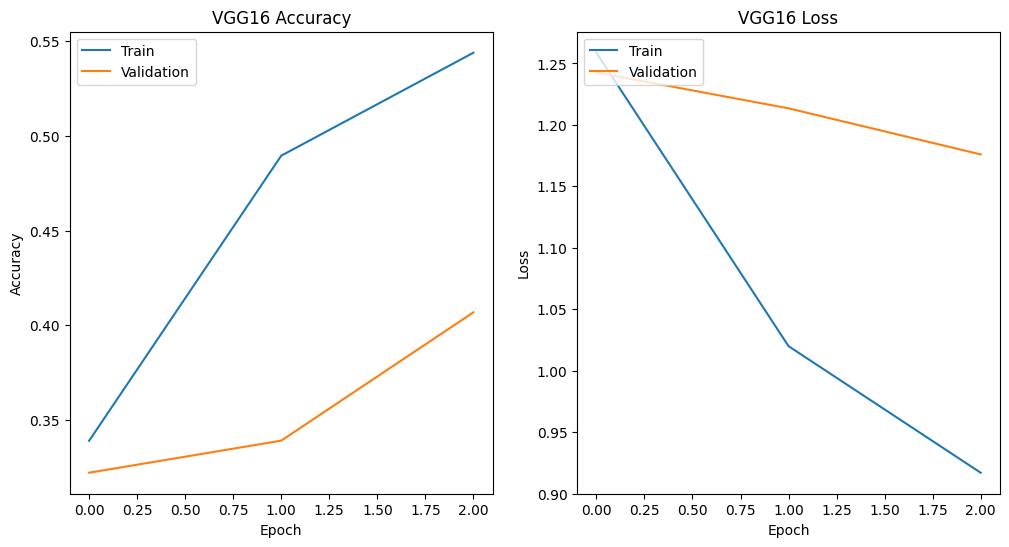

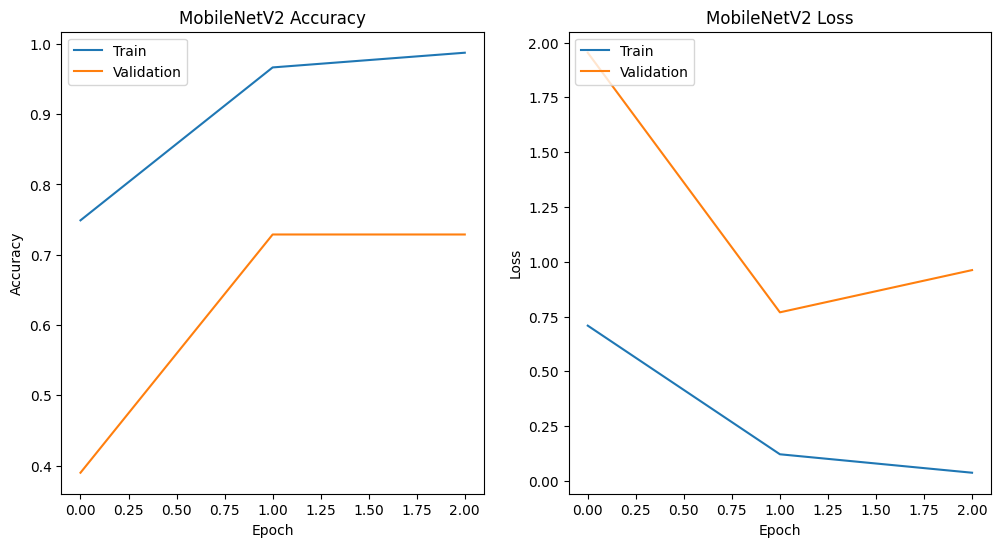

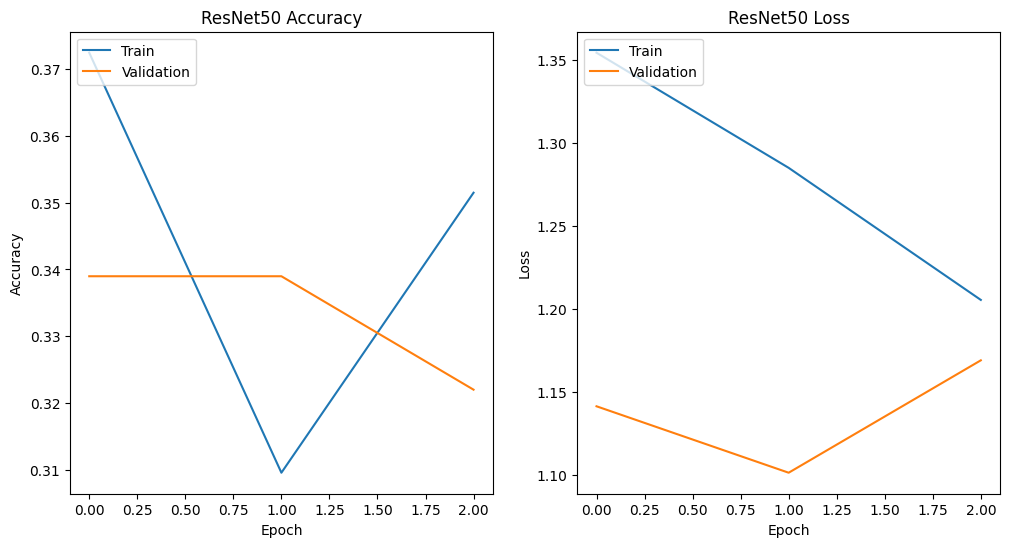


Evaluating VGG16...
2/2 [==============================] - 7s 3s/step
Classification Report for VGG16:

              precision    recall  f1-score   support

       Green       0.40      0.10      0.16        20
Mature Green       0.33      0.95      0.49        19
        Ripe       0.00      0.00      0.00        20

    accuracy                           0.34        59
   macro avg       0.24      0.35      0.22        59
weighted avg       0.24      0.34      0.21        59



c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

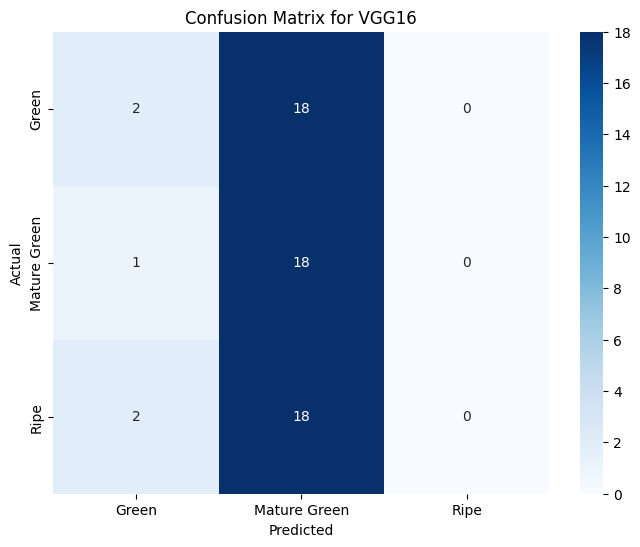


Evaluating MobileNetV2...
2/2 [==============================] - 3s 813ms/step
Classification Report for MobileNetV2:

              precision    recall  f1-score   support

       Green       0.45      0.45      0.45        20
Mature Green       0.31      0.58      0.41        19
        Ripe       0.00      0.00      0.00        20

    accuracy                           0.34        59
   macro avg       0.25      0.34      0.29        59
weighted avg       0.25      0.34      0.28        59



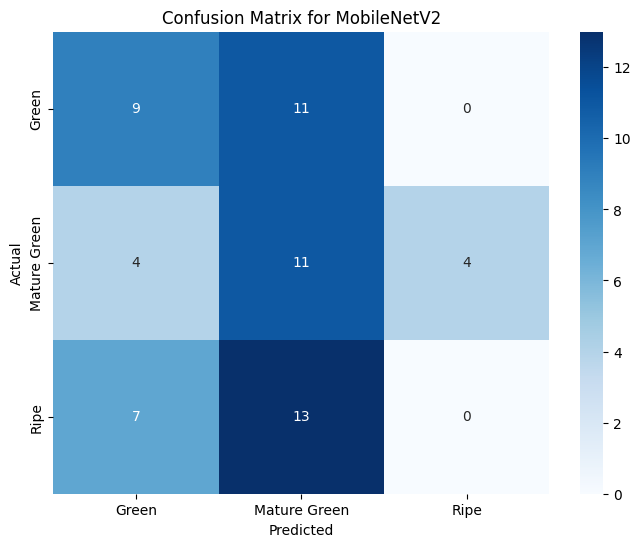


Evaluating ResNet50...
2/2 [==============================] - 5s 1s/step
Classification Report for ResNet50:

              precision    recall  f1-score   support

       Green       0.00      0.00      0.00        20
Mature Green       0.32      1.00      0.49        19
        Ripe       0.00      0.00      0.00        20

    accuracy                           0.32        59
   macro avg       0.11      0.33      0.16        59
weighted avg       0.10      0.32      0.16        59



c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

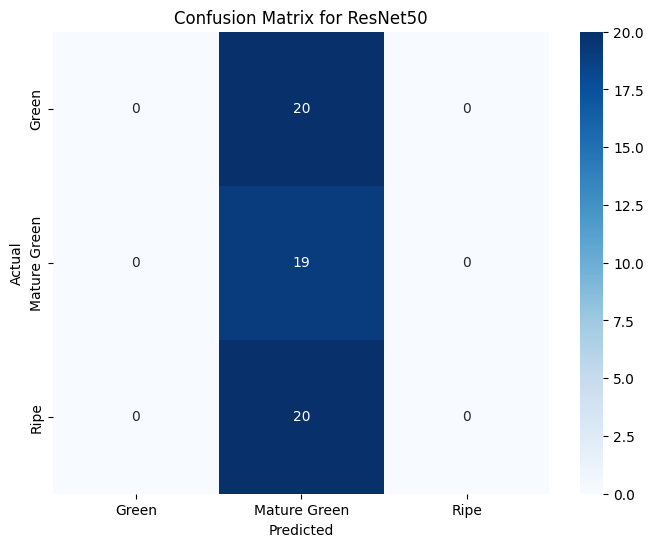


Evaluating VisionTransformer...
2/2 [==============================] - 14s 5s/step
Classification Report for VisionTransformer:

              precision    recall  f1-score   support

       Green       0.00      0.00      0.00        20
Mature Green       0.32      1.00      0.49        19
        Ripe       0.00      0.00      0.00        20

    accuracy                           0.32        59
   macro avg       0.11      0.33      0.16        59
weighted avg       0.10      0.32      0.16        59



c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MANSI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

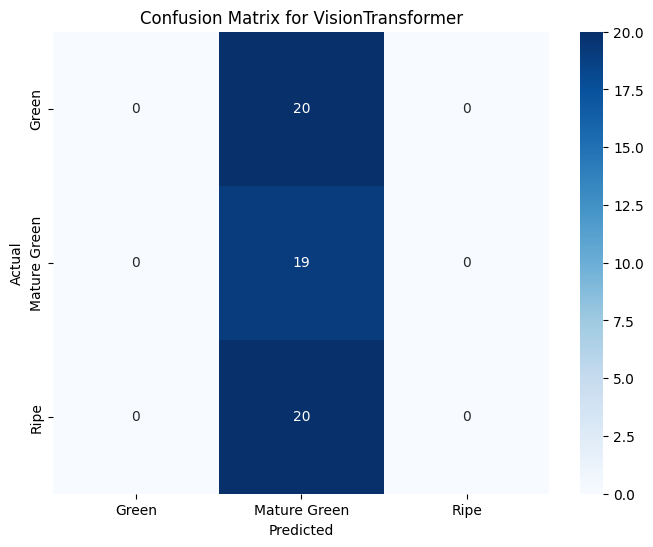

KeyError: 'VisionTransformer'

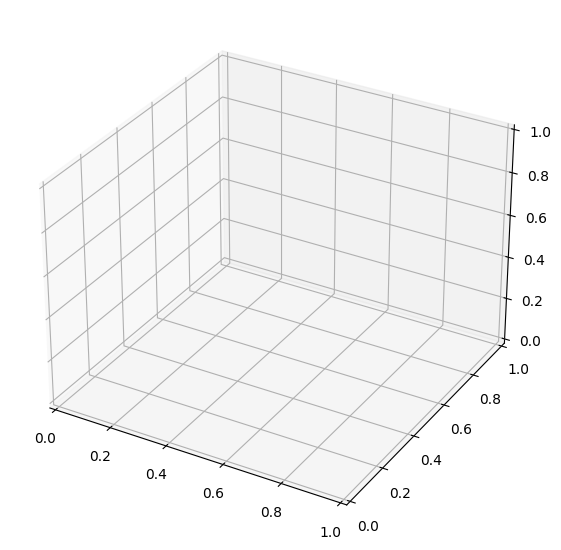

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Assuming history_dict and models are defined as in the previous code snippet

# Function to plot learning curves
def plot_learning_curves(history, title):
    plt.figure(figsize=(12, 6))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

# Function to plot classification report and confusion matrix
def plot_classification_report_and_confusion_matrix(model_name, y_true, y_pred):
    print(f'Classification Report for {model_name}:\n')
    report = classification_report(y_true, y_pred, target_names=['Green', 'Mature Green', 'Ripe'])
    print(report)
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Green', 'Mature Green', 'Ripe'], yticklabels=['Green', 'Mature Green', 'Ripe'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot learning curves for each model
for name, history in history_dict.items():
    plot_learning_curves(history, name)

# Plot classification metrics for each model
for name, model in models.items():
    print(f'\nEvaluating {name}...')
    y_pred = model.predict(validation_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = validation_generator.classes
    
    plot_classification_report_and_confusion_matrix(name, y_true, y_pred_classes)

# Extract accuracy values
accuracies = {name: history.history['accuracy'][-1] for name, history in history_dict.items()}
val_accuracies = {name: history.history['val_accuracy'][-1] for name, history in history_dict.items()}

# Plotting 3D and 2D bar plots
fig = plt.figure(figsize=(15, 8))

# 3D Bar Plot
ax1 = fig.add_subplot(121, projection='3d')

xpos = np.arange(len(models))
ypos = [0, 1]
xpos, ypos = np.meshgrid(xpos, ypos, indexing="ij")

xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)

dx = dy = 0.5
dz_train = [accuracies[name] for name in models.keys()]
dz_val = [val_accuracies[name] for name in models.keys()]
dz = np.array([dz_train, dz_val]).flatten()

colors = ['skyblue' if i % 2 == 0 else 'lightcoral' for i in range(len(dz))]

ax1.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors, alpha=0.8)
ax1.set_title('3D Bar Plot of Accuracies')
ax1.set_xticks(np.arange(len(models)))
ax1.set_xticklabels(models.keys())
ax1.set_ylabel('Type')
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['Train', 'Validation'])
ax1.set_zlabel('Accuracy')

# 2D Bar Plot
ax2 = fig.add_subplot(122)

x = np.arange(len(models))
width = 0.35

ax2.bar(x - width/2, accuracies.values(), width, label='Train Accuracy')
ax2.bar(x + width/2, val_accuracies.values(), width, label='Validation Accuracy')

ax2.set_xticks(x)
ax2.set_xticklabels(models.keys())
ax2.set_ylabel('Accuracy')
ax2.set_title('2D Bar Plot of Accuracies')
ax2.legend()

plt.show()


In [4]:
history_dict = {}
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    history = model.fit(train_generator, validation_data=validation_generator, epochs=5)
    history_dict[name] = history
    results[name] = {
        "accuracy": history.history['accuracy'][-1],
        "val_accuracy": history.history['val_accuracy'][-1],
        "loss": history.history['loss'][-1],
        "val_loss": history.history['val_loss'][-1]
    }


# Plot learning curves
plt.figure(figsize=(12, 8))

for name, history in history_dict.items():
    plt.plot(history.history['accuracy'], label=f'{name} Training Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'{name} Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))

for name, history in history_dict.items():
    plt.plot(history.history['loss'], label=f'{name} Training Loss')
    plt.plot(history.history['val_loss'], label=f'{name} Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


NameError: name 'models' is not defined

In [2]:

import matplotlib.pyplot as plt
import numpy as np

# Extract accuracy values
accuracies = {name: history.history['accuracy'][-1] for name, history in history.items()}
val_accuracies = {name: history.history['val_accuracy'][-1] for name, history in history_dict.items()}

# Plotting
fig = plt.figure(figsize=(15, 8))

# 3D Bar Plot
ax1 = fig.add_subplot(121, projection='3d')

xpos = np.arange(len(models))
ypos = [0, 1]
xpos, ypos = np.meshgrid(xpos, ypos, indexing="ij")

xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)

dx = dy = 0.5
dz = [accuracies[name] for name in models.keys()] * 2  # Duplicate for both train and validation accuracies

ax1.bar3d(xpos, ypos, zpos, dx, dy, dz, color='skyblue', alpha=0.8)
ax1.set_title('3D Bar Plot of Accuracies')
ax1.set_xticks(np.arange(len(models)))
ax1.set_xticklabels(models.keys())
ax1.set_ylabel('Accuracy')
ax1.set_zlabel('Value')

# 2D Bar Plot
ax2 = fig.add_subplot(122)

x = np.arange(len(models))
width = 0.4

train_accuracies = [accuracies[name] for name in models.keys()]
val_accuracies = [val_accuracies[name] for name in models.keys()]

ax2.bar(x - width/2, train_accuracies, width, label='Train Accuracy')
ax2.bar(x + width/2, val_accuracies, width, label='Validation Accuracy')

ax2.set_xticks(x)
ax2.set_xticklabels(models.keys())
ax2.set_ylabel('Accuracy')
ax2.set_title('2D Bar Plot of Accuracies')
ax2.legend()

plt.show()




NameError: name 'history' is not defined